In [25]:
import json
import copy
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras_tuner
from dataclasses import dataclass
from typing import List
from keras import layers, ops
from keras.utils import timeseries_dataset_from_array
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
%matplotlib inline

from processing import Stationarizer, Normalizer
from analysis import get_trials, get_RMSEs, make_histogram, plot_lrs, get_trials_df
from plotting import visualize_loss, show_plot
from model_builder import build_model, build_spec_model, get_tuner

In [26]:
trials = list()
for n in range(100):
    path = f"tuning/stock_predictor/trial_{n:03d}/trial.json"
    with open(path, mode="r") as f:
        trial = json.load(f)
        trials.append(trial)

In [27]:
def sort(array):
    """Sort the array by using quicksort."""

    less = []
    equal = []
    greater = []

    if len(array) > 1:
        pivot = array[0]["score"]
        for x in array:
            if x["score"] < pivot:
                less.append(x)
            elif x["score"] == pivot:
                equal.append(x)
            elif x["score"] > pivot:
                greater.append(x)
        return sort(less)+equal+sort(greater)
    else:
        return array

In [28]:
sorted_trials = sort(trials)
tmp = copy.deepcopy(sorted_trials)
rmse_trials = list()
for trial in tmp:
    trial.update({"score" : np.sqrt(trial["score"])})
    rmse_trials.append(trial)

In [29]:
bins = np.linspace(min([x["score"] for x in rmse_trials]), max([x["score"] for x in rmse_trials]), 25)

In [30]:
counts = [[cutoff, 0] for cutoff in bins]
t = 0
c = 0
while t < len(rmse_trials) and c < len(counts):
    if rmse_trials[t]["score"] <= counts[c][0]:
        counts[c][1] += 1
        t += 1
    else:
        c += 1

np.sum([el[1] for el in counts])

100

Text(0.5, 1.0, 'Score distribution')

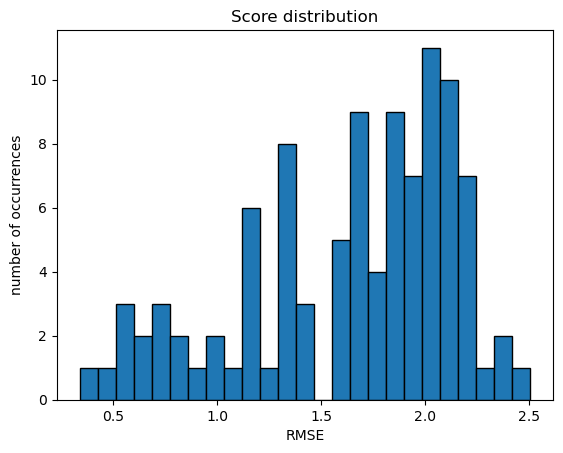

In [31]:
scx = list()
heights = list()
for el in counts:
    scx.append(el[0])
    heights.append(el[1])

plt.bar(scx, heights, edgecolor="black", width=0.088)
plt.xlabel("RMSE")
plt.ylabel("number of occurrences")
plt.title("Score distribution")

Text(0, 0.5, 'RMSE')

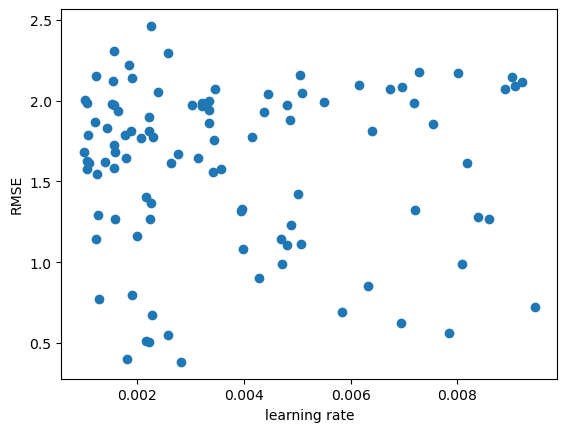

In [44]:
reg = LinearRegression()
lrs = np.array([trial["hyperparameters"]["values"]["lr"] for trial in rmse_trials])
log_lrs = np.array([np.log10(trial["hyperparameters"]["values"]["lr"]) for trial in rmse_trials])
reg.fit(lrs.reshape((-1, 1)), rmse_scores.reshape((-1, 1)))
x = np.linspace(min(lrs), max(lrs), 100)
y = reg.coef_ * x + reg.intercept_
plt.scatter(lrs, rmse_scores.reshape((-1, 1)))
#plt.plot(x, y.reshape((-1, 1)))
plt.xlabel("learning rate")
plt.ylabel("RMSE")

In [37]:
df = pd.DataFrame([trial["hyperparameters"]["values"] for trial in rmse_trials])
df["trial id"] = [trial["trial_id"] for trial in rmse_trials]
df["rmse"] = [trial["score"] for trial in rmse_trials]
df["mse"] = [trial["score"] ** 2 for trial in rmse_trials]
df["best step"] = [trial["best_step"] for trial in rmse_trials]
df

,dropout_0,kernel_initializer_0,dropout_1,kernel_initializer_1,kernel_initializer_2,lr,trial id,rmse,mse,best step
0,0.4,glorot_uniform,0.2,glorot_uniform,glorot_uniform,0.002818,065,0.383399,0.146995,45
1,0.3,glorot_uniform,0.4,glorot_uniform,he_normal,0.001811,032,0.404396,0.163536,47
2,0.3,glorot_uniform,0.4,glorot_uniform,glorot_uniform,0.002228,019,0.504616,0.254638,48
3,0.3,glorot_uniform,0.2,glorot_uniform,he_normal,0.002172,073,0.511085,0.261208,49
4,0.3,glorot_uniform,0.4,glorot_uniform,glorot_uniform,0.002580,074,0.549600,0.302061,38
...,...,...,...,...,...,...,...,...,...,...
95,0.4,glorot_uniform,0.3,he_normal,glorot_uniform,0.007272,057,2.180150,4.753053,0
96,0.4,glorot_uniform,0.4,glorot_uniform,glorot_uniform,0.001838,063,2.219033,4.924107,2
97,0.2,glorot_uniform,0.3,he_normal,he_normal,0.002581,052,2.295507,5.269351,3
98,0.3,he_normal,0.3,he_normal,he_normal,0.001570,035,2.308602,5.329645,1


In [23]:
df.to_pickle("tuning/dataframe.pkl")

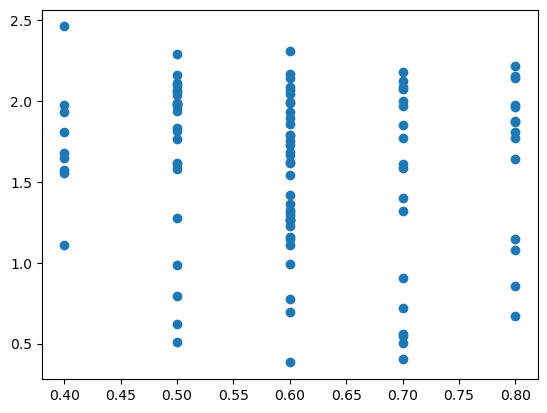

In [42]:
df["total dropout"] = df["dropout_0"] + df["dropout_1"]
plt.scatter(df["total dropout"], df["rmse"])

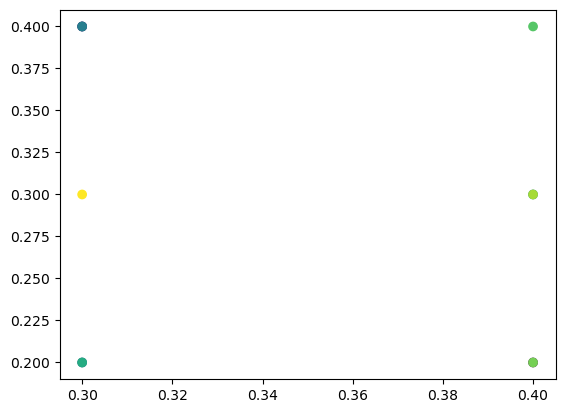

In [51]:
plt.scatter(df.loc[:10, "dropout_0"], df.loc[:10, "dropout_1"], c=df.loc[:10, "rmse"])

In [ ]:
narrow_trials = 